# Exploring image stitching.
We assume we already have a set of images to stitch, and we want to align and project them onto a global panorama image.

## Running the notebook
`bazel build //ImageStitching:jupyter & ./bazel-bin/ImageStitching/jupyter

In [1]:
import glob
import tqdm
from matplotlib.image import imread
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pickle
from PIL import Image
from scipy.optimize import least_squares
from scipy.spatial.transform import Rotation as Rot

%matplotlib notebook

debug = True

In [2]:
# 1. Load set of images
images = []
for filename in tqdm.tqdm(glob.glob("images3/*.jpg")):
    
    size = 960,960
    im = Image.open(filename)
    im.thumbnail(size, Image.ANTIALIAS)
    images.append(np.array(im))
    
    
    #img = imread(filename)
    #images.append(img)
    
with open('../CameraCalibration/sensor_models/sensor_model_iphone.pkl', 'rb') as f:
    x = pickle.load(f)
    
K = x["intrinsics"]["camera_matrix"]
num_images = len(images)

0it [00:00, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../CameraCalibration/sensor_models/sensor_model_iphone.pkl'

In [3]:
# 2. Compute features between images
# Copied form ImageMatching notebook
def get_opencv_matches(img1, img2):
    """
    Helper function that matches features between two images.
    It would be more satisfying to do this without an openCV matcher, just like
    above.
    We could either:
    a) Save all the matches in the previous function instead of just the indices
    b) Rewrite this function, building the tree just as before but just for 2 images
    The best would be a), ie in the first step we save at the very least what was the closest neighbor
    of each match (save both image index and feature)
    """
    # temp func to get keypoint matches between two images
    sift = cv.SIFT_create()
    # find the keypoints and descriptors with SIFT
    kp1, desc1 = sift.detectAndCompute(img1,None)
    kp2, desc2 = sift.detectAndCompute(img2,None)
    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(desc1,desc2,k=2)
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.4*n.distance:
            good.append(m)
            
            
    #https://stackoverflow.com/questions/30716610/how-to-get-pixel-coordinates-from-feature-matching-in-opencv-python
    list_kp1 = []
    list_kp2 = []
    for mat in good:

        # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx

        # x - columns
        # y - rows
        # Get the coordinates
        (x1, y1) = kp1[img1_idx].pt
        (x2, y2) = kp2[img2_idx].pt
        

        # Append to each list
        list_kp1.append((x1, y1))
        list_kp2.append((x2, y2))

    return np.array(list_kp1), np.array(list_kp2)

Since we focus on the registration (alignement) step, we start by using OpenCV to match features in the images, and then we compute the homography between these sets of points using RANSAC. From now on, we will perform our computations on the RANSAC inliers.

Remark: 
- By looking only at RANSAC inliers we already constrain the problem. It would be interesting to bypass this step and look at robust estimation instead (M-estimators).

<IPython.core.display.Javascript object>


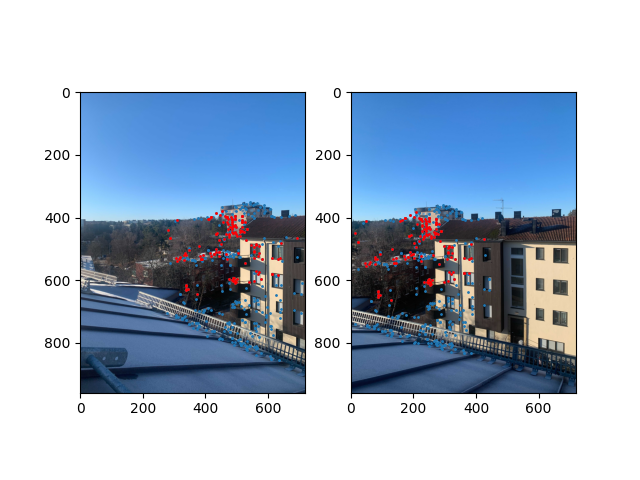

Number of inliers: 136, inliers ratio: 35.32%


In [4]:
img1 = images[1]
img2 = images[2]

list_kp1, list_kp2 = get_opencv_matches(img1[:], img2[:])

if debug:
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1)
    ax[0].scatter(*list_kp1.T, s=1)
    ax[1].imshow(img2)
    ax[1].scatter(*list_kp2.T, s=1)
    
fig.show()

# 3. Compute homography and get inliers
H, mask = cv.findHomography(list_kp2, list_kp1, cv.RANSAC, 0.5)

if debug:
    ax[0].scatter(*list_kp1[mask.flatten().astype(bool)].T, s = 1, c = "r")
    ax[1].scatter(*list_kp2[mask.flatten().astype(bool)].T, s = 1, c = "r")
    

print(f"Number of inliers: {np.sum(mask)}, inliers ratio: {100 * np.mean(mask):.2f}%")

# Optimization step
We have two sets of projected 2D points and we want to compute the best 2D transform that matches them.
We use 2D homogeneous coordinates. 

To find this transform, we need to chose a motion model. This model will be used to place constraints on how the two sets can be related with each others. 

In 2D, we could pick from the following:
- Translation, $T = \begin{bmatrix}1 & 0 & t_x\\0 & 1 & t_y\end{bmatrix}$
- Euclidian, $T = \begin{bmatrix}c_\theta & -s_\theta & t_x\\s_\theta & c_\theta & t_y\end{bmatrix}$, ie rotation and translation
- Similarity, $T = I + \begin{bmatrix}a & -b & t_x\\b & a & t_y\end{bmatrix}$
- Affine, $T = I + \begin{bmatrix}a_{00} & a_{01} & t_x\\a_{10} & a_{11} & t_y\end{bmatrix}$
- Projective, $H = I + \begin{bmatrix}h_{00} & h_{01} & h_{02}\\h_{10} & h_{11} & h_{12} \\ h_{20} & h_{21} & h_{22}\end{bmatrix}$

The more general the model is, the more precise it should be but also the more parameters it has. Therefore if performance is an issue we can choose a more restrictive model, thus reducing the degrees of freedom and improving stability.

Remark:
- Here we chose a projective model, but it would be fun to try the other ones and see how they affect the final image.

## Modeling the projective transform
We choose the projective transform, but we still need to precise it.
Since most points will be far away from the camera in a panorama, we decide to constrain the problem to rotational panoramas, which means we assume that bwteen two views the camera only rotates around its optical center, with no translation. 

Therefore, we have to compute the projective transform induces by a 3D rotation, which means it has three degrees of freedom. However, as we saw, this transform is a 3x3 matrix, therefore it can have up to 9 parameters to optimize, which is too much. We need a way to represent that transform according to the rotation.

We can write $H = K_1 R_{10} K_0^{-1}$, where $K_k = diag{f_k, f_k, 1}$ is the simplified one-parameter intrinsics matrix. We may even consider that all the images in the panorama share the intrinsics matrix.

Renmark:
- This formulation with the one-parameter intrinsics matrix is useful when the camera calibration is unknown. We remark that it does not take into account the translation of the optical center. Therefore if one want to use it as such, then they would need to express the image pixel in a normalize way, ie with coordinates in the range $(-r_x, r_x); (-r_y, r_y)$, and zero in the center. An example of such coordinates are the Normalized Device Coordinates.

In this notebook, we have the intrinsics matrix already (but pretty roughly calculated). Therefore we compute directly the optimization on normalized image points, ie points computed as $K^{-1}[u,v,1]^T$, where $K$ is already known. However, we can still choose to refine the focal length $f$ in the optimization as a kind of correction term.

## Parametrizing 3D rotations
Now we know that the core of the problem is to estimate the 3D rotation $R_{10} that relates two views (and possibly the focal length correction, but it is just a scaling factor).

There are different ways of reprensenting rotations and they can have an impact on the optimization.

- 3x3 rotation matrices have to be re-orthonormalized after each update and have too many parameters.
- Euler angles $(\alpha, \beta, \gamma)$ but you cannot move smoothly from some translations to others.
- The axis angle representation, that has 3 parameters but is still not unique.
- Unit quaternions, that represent rotations with unit 4-vectors.

In practice, axis-angles can work well for small changes, as we can then write the rotation $R(\vec{\omega}) = I + [\vec{\omega}]_x$ for small rotations, $\vec{\omega}$ beeing the 3-vector axis angle representation. Quaternions work well too.

In [5]:
norma = lambda x : x / x[:,None,2] # normalize homogeneous coordinates
homo = lambda x: np.c_[x, np.ones(x.shape[0])] # make homogeneous
normalize = lambda x: (np.linalg.inv(K) @ x.T).T # apply inverse intrinsics

def skew(x):
    """
    Return the matrix form of the cross-product operator
    """
    assert len(x) == 3
    return np.array([[0, -x[2], x[1]],
                     [x[2], 0, -x[0]],
                     [-x[1], x[0], 0]])

def reproj_loss(H, pts1, pts2):
    """
    Squared reprojection error for applying a projective transform
    to 2D homogeneous points.
    """
    H = H.reshape((3,3))
    return np.linalg.norm(pts2 - norma((H @ pts1.T).T), axis = 1) ** 2


We define different optimization functions to experiment.

In [6]:
def call_opti_H(l1, l2):
    def opti_H(H, K, pts1, pts2):
        H = np.append(H, [0])
        H = H.reshape((3,3))
        H = np.eye(3) + H
        return reproj_loss(H.reshape((-1,)), pts1, pts2)
    
    x = np.random.random((8,))
    res_3 = least_squares(opti_H, x.reshape((-1,)),
                          loss="cauchy",
                          f_scale = 0.001,
                          jac = "2-point",
                          args=(K, l2, l1))
    
    H3 = res_3.x
    H3 = np.append(H3, [0])
    H3 = H3.reshape((3,3))
    H3 = np.eye(3) + H3

    H3 = K @ H3 @ np.linalg.inv(K)
    H3 = H3 / H3[2,2]
    
    return H3

def call_opti_R_rodrig(l1, l2):
    def H_from_R_K(R, K, pts1, pts2):
        rr = Rot.from_rotvec(R).as_matrix()
        H = rr
        return reproj_loss(H.reshape((-1,)), pts1, pts2)
    
    x = np.random.random((3,))
    res_3 = least_squares(H_from_R_K, x.reshape((-1,)), args=(K, l2, l1), loss="cauchy")
    
    rr = Rot.from_rotvec(res_3.x).as_matrix()
    H3 = K @ rr @ np.linalg.inv(K) 
    H3 = H3 / H3[2,2]
    return H3

def call_opti_R_skew_f(l1, l2):
    def H_from_R_K2(R, K, pts1, pts2):
        f = R[3]
        R = [R[0]/f, R[1]/f, R[2]]
        rr = skew(R)
        H = np.eye(3) + rr
        return reproj_loss(H.reshape((-1,)), pts1, pts2)
 
    x = np.array([0,0,0,1])
    res_3 = least_squares(H_from_R_K2, x.reshape((-1,)), args=(K, l2, l1),loss="cauchy")
    
    R = res_3.x
    f = R[3]
    R = [R[0]/f, R[1]/f, R[2]]
    rr = skew(R)
    H3 = np.eye(3) + rr
    H3 = K @ H3 @ np.linalg.inv(K)
    H3 = H3 / H3[2,2]
    return H3


def call_opti_rodrig_f(l1, l2, r_guess = None):
    def H_from_R_K4(R, K, pts1, pts2):
        f = R[3]
        rr = Rot.from_rotvec(R[:3]).as_matrix()
        K2 = np.diag([f,f,1])
        rr = K2@rr @ np.linalg.inv(K2) 
        H = rr
        H = H / H[2,2]
        return reproj_loss(H.reshape((-1,)), pts1, pts2)
    
    if r_guess is not None:
        rot = Rot.from_matrix(r_guess).as_rotvec()
        x  = np.array([*rot, 1])
    else:
        x = np.random.random((4,))
        x = np.array([0,0,0,1])
    
    res_3 = least_squares(H_from_R_K4, x.reshape((-1,)),
                          loss="cauchy",
                          x_scale = [0.1,0.1,0.1,1.5],
                          f_scale = 0.001,
                          jac = "2-point",
                          args=(K, l2, l1))
    R = res_3.x
    f = R[3]
    
    rr = Rot.from_rotvec(R[:3]).as_matrix()
    K2 = np.diag([f,f,1])
    rr = K2 @rr @ np.linalg.inv(K2)
    H3 = K @ rr @ np.linalg.inv(K) 
    H3 = H3 / H3[2,2]
    return H3


def call_opti_quat_f(l1, l2, r_guess = None):
    def H_from_R_K4(R, K, pts1, pts2):
        f = R[-1]
        rr = Rot.from_quat(R[:4]).as_matrix()
        K2 = np.diag([f,f,1])
        rr = K2@rr @ np.linalg.inv(K2)
        H = rr
        H = H / H[2,2]
        return reproj_loss(H.reshape((-1,)), pts1, pts2)
    
    if r_guess is not None:
        rot_quat = Rot.from_matrix(r_guess).as_quat()
        x  = np.array([*rot_quat, 1])
    else:
        x = np.random.random((5,))
        x = np.array([0,0,0,1,1])
        
    res_3 = least_squares(H_from_R_K4, x.reshape((-1,)),
                          loss="cauchy",
                          x_scale = [0.1,0.1,0.1,0.1,1.5],
                          f_scale = 0.001,
                          jac = "2-point",
                          args=(K, l2, l1))
    R = res_3.x
    f = R[-1]
    
    rr = Rot.from_quat(R[:4]).as_matrix()
    K2 = np.diag([f,f,1])
    rr = K2 @ rr @ np.linalg.inv(K2)
    H3 = K @ rr @ np.linalg.inv(K) 
    H3 = H3 / H3[2,2]
    return H3


def call_opti_R5(l1, l2):
    def H_from_R_K5(R, K, pts1, pts2):
        f1,f2 = R[3], R[4]
        rr = Rot.from_rotvec(R[:3]).as_matrix()
        K2 = np.diag([f1,f2,1])
        rr = K2@rr @ np.linalg.inv(K2)
        H = rr
        H = H / H[2,2]
        return reproj_loss(H.reshape((-1,)), pts1, pts2)
    
    x = np.random.random((5,))
    x = np.array([0,0,0,1,1])
    res_3 = least_squares(H_from_R_K5, x.reshape((-1,)),
                          loss="cauchy",
                          x_scale = [0.1,0.1,0.1,1.5,1.5],
                          f_scale = 0.001,
                          jac = "2-point",
                          args=(K, l2, l1))
    R = res_3.x
    f1,f2 = R[3], R[4]
    
    rr = Rot.from_rotvec(R[:3]).as_matrix()
    K2 = np.diag([f1,f2,1])
    rr = K2@rr @ np.linalg.inv(K2)
    H3 = K @ rr @ np.linalg.inv(K) 
    H3 = H3 / H3[2,2]
    return H3

Comparing the different optimization approaches. In particular, we observe that the RANSAC estimation using the DLT (the OpenCV function) is not as good as the non-linear optimisation (`Opti H, H7`). This is expected as non-linear least squares should be optimal as long as the outliers are correctly modeled. Therefore **outlier rejection is not needed!**. Outliers are already handled by the optimization. 

However, it is importand to model them correctly by setting, in that case, the `f_scale` parameter that defines the margin between inlier and outlier residuals.

In [7]:
# Make the points homogeneous, filter according to RANSAC and normalize according
# to calibration matrix
l1 = np.c_[list_kp1, np.ones(len(list_kp1))]
l2 = np.c_[list_kp2, np.ones(len(list_kp2))]

#l1 = l1[mask.flatten().astype(bool)]
#l2 = l2[mask.flatten().astype(bool)]

l1_norm = (np.linalg.inv(K) @ l1.T).T
l2_norm = (np.linalg.inv(K) @ l2.T).T


# Call different optimizations
H_skew = call_opti_R_skew_f(l1_norm, l2_norm)
H_rod = call_opti_R_rodrig(l1_norm, l2_norm)
H_rod_f = call_opti_rodrig_f(l1_norm, l2_norm, np.eye(3))
H_quat = call_opti_quat_f(l1_norm, l2_norm)
H8 = call_opti_R5(l1_norm, l2_norm)
H7 = call_opti_H(l1_norm, l2_norm)

print("Skew", np.mean(reproj_loss(H_skew, l2, l1)))
print("Rodriguez", np.mean(reproj_loss(H_rod, l2, l1)))
print("Rodriguez f", np.mean(reproj_loss(H_rod_f, l2, l1)))
print("Quaternion f", np.mean(reproj_loss(H_quat, l2, l1)))
print("Rodriguez f1 f2", np.mean(reproj_loss(H8, l2, l1)))
print("Opti H", np.mean(reproj_loss(H7, l2, l1)))
print("RANSAC H", np.mean(reproj_loss(H, l2, l1)))

Skew 299.7420123924296
Rodriguez 138.2584054165563
Rodriguez f 46.92548514527328
Quaternion f 46.91783690254739
Rodriguez f1 f2 44.01694428235523
Opti H 43.111153872300626
RANSAC H 43.934446003513536


# Full pipeline
We can now define a full pipeline to process sequentially overlapping images and compute the transforms between them.
The algorithm is the fullowing, for each image:
- Match features with the previous image
- Get the RANSAC inliers of the matched features
- Compute the transform between the images using the RANSAC inliers
- Concatenate the transform with the previous ones.


Once we have all the transforms, we can rotate them so that the middle image is the one that is "flat" (instead of the left-most one). To do so we take the transform associated to the middle image and apply its inverse to all the transforms.

Finally, we can project the images into the panorama. In order to get a nice output, we need to compute the size of the new panorama.
To do so we compute the transformed coordinates of the images corners for the different transforms, to see how far away the images may be stretched / translated. Then we compute the translation that would make sure the top left corner of the panorama is (0,0), as well as the bounds of the panorama image.

Remark:
- In the explanation we assume that images are taken on a left to right motion. In practice this doesn't matter.

In [8]:
# Full pipeline for multiple images
# Following https://www.mathworks.com/help/vision/ug/feature-based-panoramic-image-stitching.html

# Init
sift = cv.SIFT_create()
bf = cv.BFMatcher()
num_images = len(images)
transforms = np.vstack([[np.eye(3)]] * num_images)
sizes = np.empty((num_images, 2))

# 1. Read the first image
img = images[0]

                    
# find the keypoints and descriptors with SIFT
kp, desc = sift.detectAndCompute(img,None)

for i in range(1, num_images):
    kp_prev  = kp
    desc_prev = desc
    
    img = images[i]
        
    kp, desc = sift.detectAndCompute(img,None)

    print(desc.shape, desc_prev.shape)
    # match
    matches = bf.knnMatch(desc_prev,desc,k=2)
    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    list_kp_prev = []
    list_kp = []
    for mat in good:
        # Get the matching keypoints for each of the images
        img_prev_idx = mat.queryIdx
        img_idx = mat.trainIdx
        # Get the coordinates
        (x1, y1) = kp_prev[img_prev_idx].pt
        (x2, y2) = kp[img_idx].pt
        # Append to each list
        list_kp_prev.append((x1, y1))
        list_kp.append((x2, y2))
        
    list_kp_prev = np.array(list_kp_prev)
    list_kp = np.array(list_kp)
        
    H, mask = cv.findHomography(list_kp, list_kp_prev, cv.RANSAC, 0.5)
    print(f"Number of inliers: {np.sum(mask)}, inliers ratio: {100 * np.mean(mask):.2f}%")
    
    
    l1 = np.c_[list_kp_prev, np.ones(len(list_kp_prev))]
    l2 = np.c_[list_kp, np.ones(len(list_kp))]
    
    # Comment / uncomment to observe the effects of outliers
    #l1 = l1[mask.flatten().astype(bool)]
    #l2 = l2[mask.flatten().astype(bool)]

    l1 = (np.linalg.inv(K) @ l1.T).T
    l2 = (np.linalg.inv(K) @ l2.T).T
    H_opti = call_opti_rodrig_f(l1, l2, np.eye(3))
    #H_opti = call_opti_H(l1, l2)
    #H_opti = call_opti_quat_f(l1, l2)
    
    transforms[i] = H_opti
    
    # Concatenate with previous transform
    transforms[i] = transforms[i] @ transforms[i-1]

(2276, 128) (1634, 128)
Number of inliers: 170, inliers ratio: 33.46%
(2510, 128) (2276, 128)
Number of inliers: 219, inliers ratio: 32.54%


We have computed the transformations in a pairwise fashion (transformation from $i-1$ to $i$, then $i$ to $i+1$, and so on), and concatenated them, by assuming the first transform to be identity. That means the first image will be our reference and we appear "flat". In order to make the output more balanced, it would be better to have the middle image flat. Thus we apply the inverse of the middle transform to the whole chain of transforms.

In [9]:
# Make the center image "flat"
centerIdx = num_images // 2
Tinv = np.linalg.inv(transforms[centerIdx])
for i in range(num_images):
    transforms[i] = transforms[i] @ Tinv

We can finally produce the panorama. The last required step is to compute the bounds of the transformed images. To do so, we take the corners of the untransformed images and apply the transforms to them, to see to which extent they will be scale and moved. Then we can compute the offset required to make sure we have no negative coordinates, and that the smallest coordinates will be $(0, 0)$, and return the final dimensions.

In [10]:
def getProjectedLimits(transforms, sizes):
    #sizes = np.vstack([sizes, [0,0]])
    xmin, xmax = 0, -np.inf
    ymin, ymax = 0, -np.inf
    for T in transforms:
        for s in sizes:
            T = T / T[2,2]
            s = np.array([s[1], s[0], 1])
            a =(T @ s.T).T
            a = a / a[2]
        
            xmin = min(xmin, a[0])
            xmax = max(xmax, a[0])
            ymin = min(ymin, a[1])
            ymax = max(ymax, a[1])
            
    
    # We compute the translation that will make xmin and ymin be (0,0)
    # We express it as a 3x3 matrix that we will compose to the panorama transforms.
    offset = np.eye(3)
    offset[:,2] = [-xmin, -ymin, 1]
    
    final_width = xmax + (-xmin)
    final_height = ymax + (-ymin)
    return offset, (int(final_width), int(final_height))
 
# Hard coded for now. These are the coordinates of the corners of the input images/
corners = np.array([
    [0, 0],
    [0, 720],
    [960, 0],
    [960, 720]
])

# create binary mask from projected image
# returns the indices of completely black pixels
def mask_from_image(img):
    out_mask = np.linalg.norm(img, axis=2) != 0
    out_mask = out_mask.astype(bool)
    idx = (out_mask==0)
    return idx

<IPython.core.display.Javascript object>


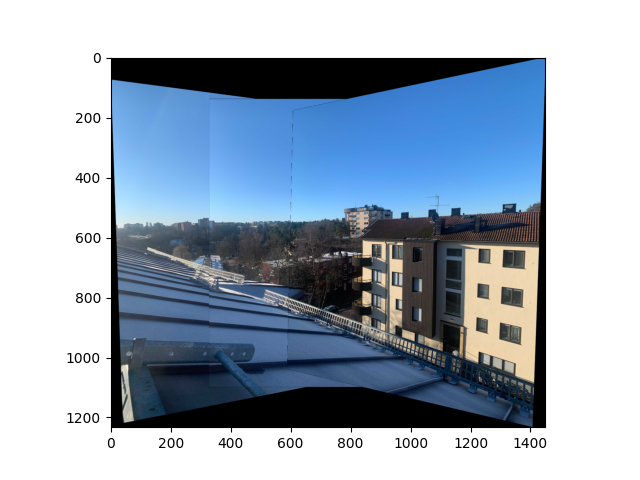

In [11]:
offset, out_size = getProjectedLimits(transforms, corners)  

# Big panorama canvas where all the images will be projected
base = np.zeros((*out_size[::-1], 3), dtype=int)
for i in range(0, num_images):
    T = offset @ transforms[i]
    out = cv.warpPerspective(images[i], T, out_size)
    
    # Find the area where the new image overlaps with the already projected 
    # previous images
    idx1 = mask_from_image(base)
    idx2 = mask_from_image(out)
    mask = np.logical_and(~idx1,~idx2)
    
    # Add the new image to the panorama and clear up the overlapping area
    base += out
    base[mask] = out[mask]# * 0.5 + base[mask] * 0.5
    
plt.figure()
plt.imshow(base)
plt.show()

# Global registration
We want to solve the problem by formulating it a bit differently. Until know we took images in a pairwise fashion and aligned them by extracting and matching features online.
Now we want to extract all features and match them in one single step. This would allow us to obtain more image correspondances. For instace, image 0 and image 2 could have some overlapping features. The previous method would not make use of that.

This formulation is quite generic and can be used in various ways, for example:
- For image $i$ and $j$, get their pairwise correspondances
- For image $i$, get all its correspondances and their respective image indices
- etc

Remark: it is always good to remember that a transform can only be applied to the whole image, so if we compute a transform to match features between images 0 and 2, but image one also matches with image 2, then we need to take that into consideration.

## Data structures
To model the problem, we choose to use arrays. This is because they are convenient and can easily be masked and operations vectorized. Since we will have very sparse arrays, they do not require too much space.

- `points_2d` of size $(n, 2)$ contains the 2D feature points coordinates (x,y) of all the features observed for all the images (first for image 0, then 1, etc).
- `image_idx` of size $(n,)$ contains the index of the image a feature point corresponds to.
- `descriptors` of size $(n, 128)$ contains the SIFT descriptors for each feature. 

As we can see, all these arrays have a one to one relationship.

We also have:
- `matches_bools` of size $(n, n)$ that acts as an incidence matrix, indicating which features match with each other with a boolean.

In [23]:
# Build the array points_2d of size (n_observations, 2) with all the features (no match information stored yet)
points_2d = np.zeros((0,2))
# Build the image_idx array of size (n_observations,) that indicates to which image each point belongs to
image_idx = np.empty((0,))
# Build the arrays of descriptors, that will be used for matching points (not for the optimization)
descriptors = np.empty((0,128), dtype=np.float32)

# Init
sift = cv.SIFT_create()
bf = cv.BFMatcher()
num_images = len(images)

for i, img in enumerate(images):
    kp, desc = sift.detectAndCompute(img,None)
    list_kp = np.array([x.pt for x in kp])

    # Concatenate all the new information related to that image
    points_2d = np.vstack([points_2d, list_kp])
    descriptors = np.vstack([descriptors, desc])
    image_idx = np.append(image_idx, np.ones((list_kp.shape[0])) * i)

In [25]:
# Build the array of booleans of size (n_observations, n_images) that indicates to which image each feature has matched
#matches_bools = np.zeros((descriptors.shape[0], num_images), dtype=bool)
matches_bools = np.zeros((descriptors.shape[0], descriptors.shape[0]), dtype = bool)

# Now we need to match all the descriptors together accross images
# For simplicity's sake, we'll use a brute force approach of trying to mach every image with the others
import itertools
image_couple_indices = list(itertools.permutations([x for x in range(num_images)], r=2))

bf = cv.BFMatcher()
for img_idx_1, img_idx_2 in image_couple_indices:
    desc1 = descriptors[np.where(image_idx == img_idx_1)]
    desc2 = descriptors[np.where(image_idx == img_idx_2)]
    matches = bf.knnMatch(desc1,desc2,k=2)

    # Apply ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    for mat in good:
        # Get the matching keypoints for each of the images
        # Explanation:
        # np.where(image_idx == img_idx_1)[0] are the rows corresponding to the image we look at
        # mat.queryIdx is the particular row that matched within the set of image rows
        desc1_idx = np.where(image_idx == img_idx_1)[0][mat.queryIdx]
        desc2_idx = np.where(image_idx == img_idx_2)[0][mat.trainIdx]
        # Matches are undirected
        matches_bools[desc1_idx, desc2_idx] = True
        matches_bools[desc2_idx, desc1_idx] = True
        
print(f"Total matches: {matches_bools.sum()}")

Total matches: 3338


In [26]:
# Points that match between image i and image j
def get_matches_between_images(i, j, matches_bools, image_idx):
    """
    From the table of matches, filters the points that match between image
    indices i and j. 
    Then return the indices of the corresponding feature points in images i and j.
    """
    img_i_idx = np.where(image_idx == i)[0]
    img_j_idx = np.where(image_idx == j)[0]

    img_ij_matches = np.argwhere(matches_bools[img_i_idx.reshape(-1,1), img_j_idx])

    matches_in_i_idx = img_i_idx[img_ij_matches[:,0]]
    matches_in_j_idx = img_j_idx[img_ij_matches[:,1]]
    
    return matches_in_i_idx, matches_in_j_idx

<IPython.core.display.Javascript object>


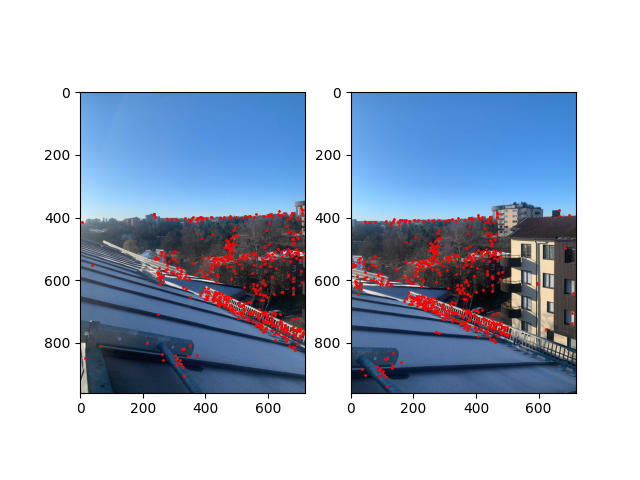

In [27]:
# debug
i, j = 0, 1
matches_in_i_idx, matches_in_j_idx = get_matches_between_images(i, j, matches_bools, image_idx)
matches_in_i = points_2d[matches_in_i_idx]
matches_in_j = points_2d[matches_in_j_idx]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[i])
ax[0].scatter(*matches_in_i.T, s=1, c="r")
ax[1].imshow(images[j])
ax[1].scatter(*matches_in_j.T, s=1, c="r")
plt.show()

## Optimization
Now we can optimize the parameters. We have as many transforms $T_i$ to compute as we have images.
We define `fun`, that computes the total reprojection error associated with one or more pairs of images.

The main idea is to gradually optimize for the whole set of transforms: first we only optimize for two images, then we add a third, and so on. As we are optimizing by looking at pairwise matches, every time we add an image to the optimization the number of pairs to check increases. To keep the optimization stable, we use as a first guess the transforms that were computed at the previous step. Then every new step consists in computing the transform for the new image, and possibly refine the previous transforms.

In [28]:
"""
Compute the reprojection errors induced by applying a transform to matching feature points
between two images.
Returns the concatenation of errors over multiple pairs.

- image_couple_indices of size (nb_pairs, 2) indicates the pairs of images we want to fit.

The transform is applied to the second image, which means we compute transformes of images relative
to their neighbors, and that the global transforms by concatenation later on.
"""
def fun(x0, points_2d, matches_bools, image_idx, num_images, image_couple_indices):
    transforms = x0.reshape((num_images, -1))
    total_error = []
    
    for i, j in image_couple_indices:
        T_i = transforms[i]#.reshape((3,3))
        T_j = transforms[j]#.reshape((3,3))
        T_i = np.append(T_i, [1]).reshape((3,3))
        T_j = np.append(T_j, [1]).reshape((3,3))
        matches_in_i_idx, matches_in_j_idx = get_matches_between_images(i, j, matches_bools, image_idx)

        matches_in_i = points_2d[matches_in_i_idx]
        matches_in_j = points_2d[matches_in_j_idx]
        
        pts1 = normalize(homo(matches_in_i))
        pts2 = normalize(homo(matches_in_j))
        
        #pts1 = (T_i @ pts1.T).T
        pts2 = (T_j @ pts2.T).T

        err = reproj_loss(np.eye(3), pts2, pts1) #applies T to arg1
        total_error.extend(err)

    return total_error

We optimize for a full homography, but we could have chosen a simpler motion model as shown above.

In [29]:
# Array of transforms from image i to image j
T_parameters = 8
T_guess = np.eye(3).reshape((-1,))[:T_parameters]
f_parameters = 0
f_guess = 1.1
transforms = np.empty((num_images, T_parameters + f_parameters))

transforms[:] = T_guess

#image_couple_indices = list(itertools.combinations([x for x in range(num_images)], r=2))
image_couple_indices = [(0,2), (1,2), (0,1)]#, (1,2), {0,2}]   
for i in range(0,len(image_couple_indices)):
    print("Estimating on: ", image_couple_indices[:i+1] )
    x0 = transforms.ravel()
    res = least_squares(fun,
                        x0,
                        #jac_sparsity=A,
                        verbose=1,
                        ftol=1e-5,
                        loss="cauchy",
                        f_scale = 0.001,
                        args=(points_2d, matches_bools, image_idx, num_images, image_couple_indices[:i+1]))
    
    T = res.x.reshape((num_images, -1))
    for i, j in image_couple_indices:
        #transforms[i] = T[i].reshape((-1,))
        transforms[j] = T[j].reshape((-1,))
  
transforms = np.c_[transforms, np.ones(T.shape[0])]
transforms = transforms.reshape((num_images, 3, 3))
transforms = K @ transforms @ np.linalg.inv(K) 

Estimating on:  [(0, 2)]
`ftol` termination condition is satisfied.
Function evaluations 111, initial cost 2.0345e-03, final cost 3.0116e-04, first-order optimality 1.46e-05.
Estimating on:  [(0, 2), (1, 2)]
`ftol` termination condition is satisfied.
Function evaluations 100, initial cost 4.3940e-03, final cost 1.9540e-03, first-order optimality 4.21e-05.
Estimating on:  [(0, 2), (1, 2), (0, 1)]
`ftol` termination condition is satisfied.
Function evaluations 64, initial cost 5.0316e-03, final cost 2.1847e-03, first-order optimality 3.61e-05.


In [31]:
for t in transforms:
    print(t/t[2,2])
    print()

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

[[ 8.41208747e-01 -8.81409547e-03  2.41420769e+02]
 [-8.02144957e-02  9.99802630e-01 -9.51386599e+00]
 [-2.65605478e-04  5.43031583e-05  1.00000000e+00]]

[[ 7.32882617e-01 -1.91167455e-02  2.82125222e+02]
 [-1.14089472e-01  9.11796408e-01  2.43940131e+01]
 [-3.16982462e-04 -1.14755088e-05  1.00000000e+00]]



In [32]:
# Since we compute poses relative to each other, we need to concatenate them.
for i in range(1, num_images):
    transforms[i] = transforms[i] @ transforms[i-1]
    
# Make the center image "flat"
centerIdx = num_images // 2
Tinv = np.linalg.inv(transforms[centerIdx])
for i in range(num_images):
    transforms[i] = transforms[i] @ Tinv

<IPython.core.display.Javascript object>


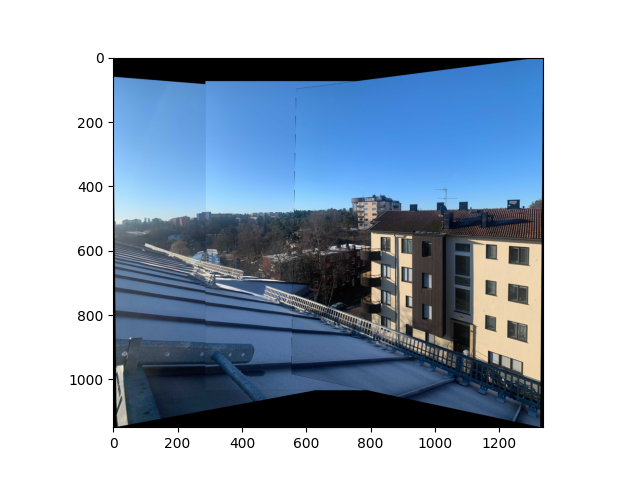

In [33]:
offset, out_size = getProjectedLimits(transforms, corners)  

# Big panorama canvas where all the images will be projected
base = np.zeros((*out_size[::-1], 3), dtype=int)
for i in range(0, num_images):
    T = offset @ transforms[i]
    out = cv.warpPerspective(images[i], T, out_size)
    
    # Find the area where the new image overlaps with the already projected 
    # previous images
    idx1 = mask_from_image(base)
    idx2 = mask_from_image(out)
    mask = np.logical_and(~idx1,~idx2)
    
    # Add the new image to the panorama and clear up the overlapping area
    base += out
    base[mask] = out[mask]# * 0.5 + base[mask] * 0.5
    
plt.figure()
plt.imshow(base)
plt.show()